In [1]:
from nnodely import *
from nnodely.support import earlystopping
import matplotlib.pyplot as plt
import os
import numpy as np

workspace = os.path.join(os.getcwd(), "saved_models")
inverted_pendulum = Modely(workspace=workspace)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>-- nnodely_v1.5.2 --<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


In [2]:
# Create neural model
model_name = 'unstructured_neural_model'
pos                 = Input('Xpos')
Ypos                = Input('Ypos')
Xvelocity           = Input('Xvelocity')
Xangular_velocity   = Input('Xangular_velocity')
Yvelocity           = Input('Yvelocity')
angle               = Input('Xangle')
Yangle              = Input('Yangle')
Yangular_velocity   = Input('Yangular_velocity')
F                   = Input('action')

noise1          = Input('noise1')
noise2          = Input('noise2')
noise3          = Input('noise3')
noise4          = Input('noise4')
sigma_x         = Constant('sigma_x', values=0.0)
sigma_v         = Constant('sigma_v', values=0.0)
sigma_theta     = Constant('sigma_theta', values=0.0)
sigma_omega     = Constant('sigma_omega', values=0.0)

g               = Constant('g', values=9.81)
dt              = Constant('dt', values=0.02)

sw = 1
# Adding noise to the inputs
x_noisy = Fir(pos.sw(sw) + noise2.sw(sw)*sigma_x)
vel_noisy = Fir(Xvelocity.sw(sw) + noise1.sw(sw)*sigma_v)
ang_vel_noisy = Fir(Xangular_velocity.sw(sw) + noise3.sw(sw) * sigma_omega)
theta_noisy = Fir(angle.sw(sw) + noise4.sw(sw) * sigma_theta)

# MLP
hidden_dim = 10
l_ang = Linear(output_dimension=hidden_dim)(theta_noisy)
l_pos = Linear(output_dimension=hidden_dim)(x_noisy)
l_vel = Linear(output_dimension=hidden_dim)(vel_noisy)
l_ang_vel = Linear(output_dimension=hidden_dim)(ang_vel_noisy)
l_sin = Linear(output_dimension=hidden_dim)(Sin(theta_noisy))
l_cos = Linear(output_dimension=hidden_dim)(Cos(theta_noisy))
l_force = Linear(output_dimension=hidden_dim)(F.last())
emb = Tanh(l_ang+l_pos+l_vel+l_ang_vel+l_sin+l_cos+l_force)

# Update state variables
xdot = Linear(Tanh(Linear(output_dimension=hidden_dim)(emb)))
xdot.closedLoop(Xvelocity)

x = Linear(Tanh(Linear(output_dimension=hidden_dim)(emb)))
x.closedLoop(pos)

thetadot = Linear(Tanh(Linear(output_dimension=hidden_dim)(emb)))
thetadot.closedLoop(Xangular_velocity)

theta = Linear(Tanh(Linear(output_dimension=hidden_dim)(emb)))
theta.closedLoop(angle)

# Output and loss
est_theta = Output('est_theta', theta)
est_thetadot = Output('est_thetadot', thetadot)
est_xdot = Output('est_xdot', xdot)
est_x = Output('est_x', x)

inverted_pendulum.addModel('pendulum', [est_thetadot, est_theta, est_xdot, est_x])
inverted_pendulum.addMinimize('ang_vel_error', Yangular_velocity.last(), thetadot, loss_function='mse')
inverted_pendulum.addMinimize('angle_error', Yangle.last(), theta, loss_function='mse')
inverted_pendulum.addMinimize('vel_error', Yvelocity.last(), xdot, loss_function='mse')
inverted_pendulum.addMinimize('pos_error', Ypos.last(), x, loss_function='mse')
inverted_pendulum.neuralizeModel(sample_time = 0.02)

[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'sigma_omega': {'dim': 1, 'values': [0.0]},
               'sigma_theta': {'dim': 1, 'values': [0.0]},
               'sigma_v': {'dim': 1, 'values': [0.0]},
               'sigma_x': {'dim': 1, 'values': [0.0]}},
 'Functions': {},
 'Info': {'SampleTime': 0.02,
          'nnodely_version': '1.5.2',
          'ns': [1, 0],
          'ntot': 1,
          'num_parameters': 514},
 'Inputs': {'Xangle': {'closedLoop': 'Linear61',
                       'dim': 1,
                       'local': 1,
                       'ns': [1, 0],
                       'ntot': 1,
                       'sw': [-1, 0]},
            'Xangular_

In [7]:
# Data loading and Training
data_struct = ['time', 'action', 'Xpos', 'Xangle', 'Xvelocity', 'Xangular_velocity', 'Ypos', 'Yangle', 'Yvelocity', 'Yangular_velocity', 'noise1', 'noise2', 'noise3', 'noise4']
data_folder = os.path.join(os.path.abspath(''), 'data')
inverted_pendulum.loadData(name='data', source=data_folder, format=data_struct, delimiter=',', header=0)

prediction_samples = None
step = None
early_stop_patience = 10
inverted_pendulum.exportPythonModel(name=model_name)
inverted_pendulum.importPythonModel(name=model_name)
inverted_pendulum.neuralizeModel(sample_time = 0.02)
params = {'train_batch_size':64, 'num_of_epochs':500}
inverted_pendulum.trainModel(splits=[100,0,0], optimizer='Adam', prediction_samples=prediction_samples, step=step, training_params=params, early_stopping=earlystopping.early_stop_patience,  
                                                            early_stopping_params={'patience':early_stop_patience, 'error':'ang_vel_error'}, lr=1e-3)
inverted_pendulum.exportPythonModel(name=model_name)
inverted_pendulum.exportReport(name=model_name+'_report')


============================ nnodely Model Dataset =============================
Dataset Name:                 data
Number of files:              200
Total number of samples:      30000
Shape of Xpos:                (30000, 1, 1)
Shape of action:              (30000, 1, 1)
Shape of noise4:              (30000, 1, 1)
Shape of Xangle:              (30000, 1, 1)
Shape of noise3:              (30000, 1, 1)
Shape of Xangular_velocity:   (30000, 1, 1)
Shape of noise1:              (30000, 1, 1)
Shape of Xvelocity:           (30000, 1, 1)
Shape of noise2:              (30000, 1, 1)
Shape of Ypos:                (30000, 1, 1)
Shape of Yvelocity:           (30000, 1, 1)
Shape of Yangle:              (30000, 1, 1)
Shape of Yangular_velocity:   (30000, 1, 1)
=============================== Save JSON Model ================================
Model saved in:               /home/baro/Desktop/inv_pend/saved_models/data_driven_model.json
========================== Export Python Torch Model ==============

=============================== Load JSON Model ================================
Model loaded from:            /home/baro/Desktop/inv_pend/saved_models/data_driven_model.json
[neuralizeModel] Closed loop on Xangle with sample in the future.
[neuralizeModel] Closed loop on Xangular_velocity with sample in the future.
[neuralizeModel] Closed loop on Xpos with sample in the future.
[neuralizeModel] Closed loop on Xvelocity with sample in the future.
================================ nnodely Model =================================
{'Constants': {'sigma_omega': {'dim': 1, 'values': [0.0]},
               'sigma_theta': {'dim': 1, 'values': [0.0]},
               'sigma_v': {'dim': 1, 'values': [0.0]},
               'sigma_x': {'dim': 1, 'values': [0.0]}},
 'Functions': {},
 'Info': {'SampleTime': 0.02,
          'nnodely_version': '1.5.2',
          'ns': [1, 0],
          'ntot': 1,
          'num_parameters': 514},
 'Inputs': {'Xangle': {'closedLoop': 'Linear133',
                       '

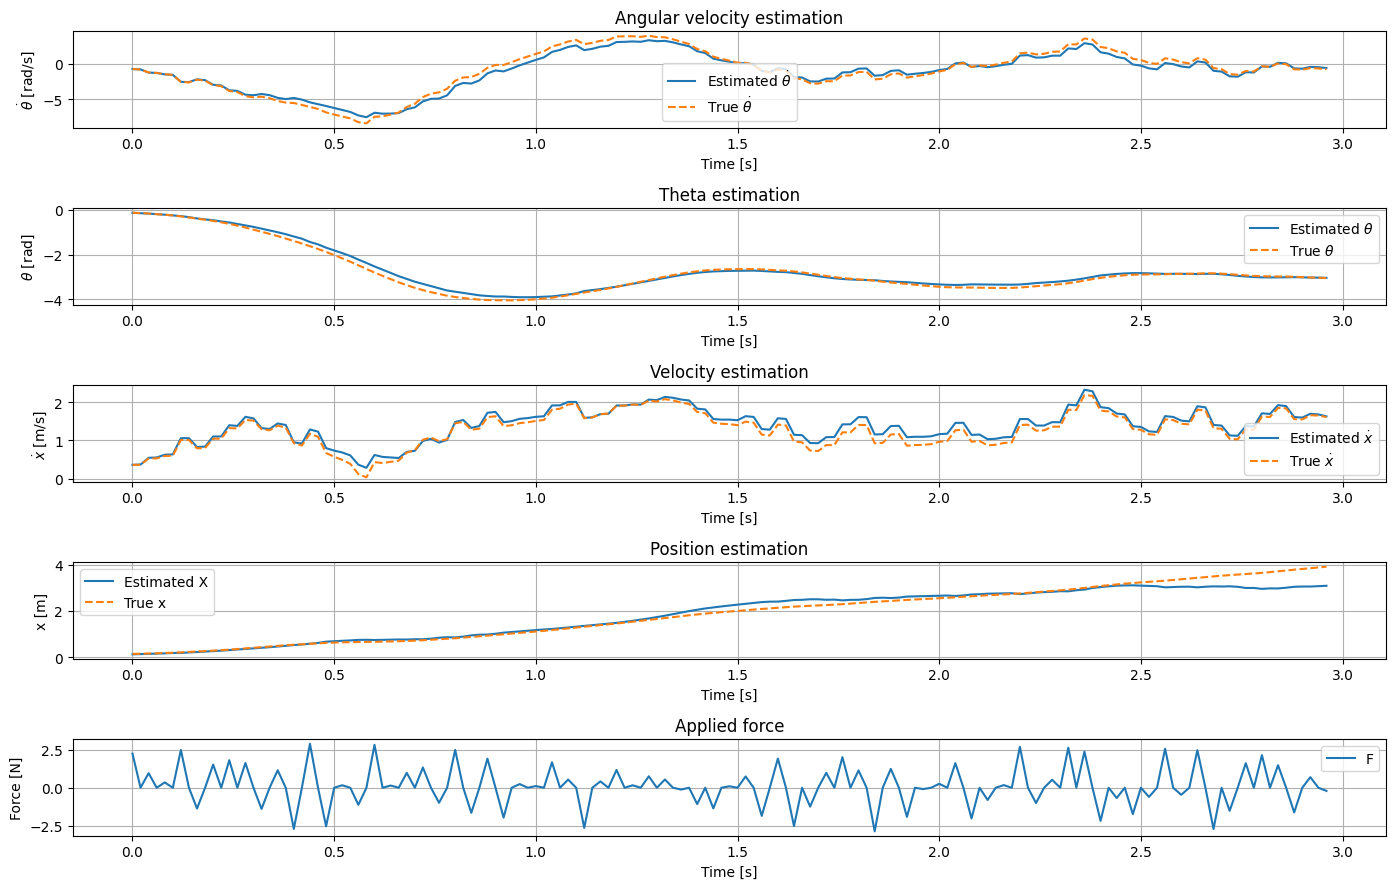

In [ ]:
# Closed-loop plot
data_struct = ['time', 'action', 'Xpos', 'Xangle', 'Xvelocity', 'Xangular_velocity', 'Ypos', 'Yangle', 'Yvelocity', 'Yangular_velocity', 'noise1', 'noise2', 'noise3', 'noise4']
inverted_pendulum.importPythonModel(name=model_name)
inverted_pendulum.neuralizeModel(sample_time = 0.02)
data_folder = os.path.join(os.path.abspath(''), 'data_test')
inverted_pendulum.loadData(name='data_test', source=data_folder, format=data_struct, delimiter=',', header=0)
samples = inverted_pendulum.getSamples(dataset='data_test', window=150, index=0)
result = inverted_pendulum(samples, sampled=True, prediction_samples=150)

# Plotting
t = np.arange(len(result['est_theta'])) * 0.02
plt.figure(figsize=(14, 9))
plt.subplot(5, 1, 2)
plt.plot(t, result['est_theta'], label=r'Estimated $\theta$')
plt.plot(t, np.array(samples['Yangle']).squeeze(), '--', label=r'True $\theta$')
plt.title('Theta estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\theta$ [rad]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 1)
plt.plot(t, result['est_thetadot'], label=r'Estimated $\dot{\theta}$')
plt.plot(t, np.array(samples['Yangular_velocity']).squeeze(), '--', label=r'True $\dot{\theta}$')
plt.title('Angular velocity estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\dot{\theta}$ [rad/s]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 4)
plt.plot(t, result['est_x'], label='Estimated X')
plt.plot(t, np.array(samples['Ypos']).squeeze(), '--', label='True x')
plt.title('Position estimation')
plt.xlabel('Time [s]')
plt.ylabel('x [m]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 3)
plt.plot(t, result['est_xdot'], label=r'Estimated $\dot{x}$')
plt.plot(t, np.array(samples['Yvelocity']).squeeze(), '--', label=r'True $\dot{x}$')
plt.title('Velocity estimation')
plt.xlabel('Time [s]')
plt.ylabel(r'$\dot{x}$ [m/s]')
plt.grid()
plt.legend()
plt.subplot(5, 1, 5)
plt.plot(t, np.array(samples['action']).squeeze(), label='F')
plt.title('Applied force')
plt.xlabel('Time [s]')
plt.ylabel('Force [N]')
plt.grid()
plt.legend()
plt.tight_layout()

img_name = model_name + '_closed_loop.png'
save_path = os.path.join(os.getcwd(), "results", "imgs", img_name)
#plt.savefig(save_path, dpi=300)
plt.show()